In [1]:
# The following classes find continuous AMFM or FM pulses with a local minimum in fidelity loss due to motional entanglement
# FM is technically a type of AMFM (with constant amplitude)
# We assume we can scale the amplitude (Omega) linearly to satisfy double integral phi = pi/4
# Mode structure is not required to achieve optimization

import matplotlib.pyplot as plt
import numpy as np

from numpy import *
from scipy.integrate import *
from scipy.optimize import minimize

class continuous_opt:
    
    # Optimization for continuous pulses
    # FM_XXGate and AM_FM_XXGate will inherit from this class
    
    def __init__(self, w_k, tau, max_amp, amp, init_freq, init_beta, beam_geom, real_units):
        
        self.w_k = w_k      # Mode Frequencies [n_ion x 1] vector in angular units if real
        self.w = array(w_k) / 2 / pi                             # List of mode frequencies in real units
        
        self.n_ions = len(w_k)                                   # Number of ions = number of modes
        
        self.tau = tau                                           # Total gate time
        self.steps = len(amp)                                    # Number of time steps (e.g. 5000)
        self.dt = tau / self.steps                               # Length of time step
        self.tseg = asarray(range(self.steps)) / \
                    self.steps * tau                             # Segmented time array
        
        self.max_amp = max_amp                                   # Maximum amplitude (carrier Rabi frequency)
        self.amp = array(amp) / max(amp) * max_amp               # AM pattern (scaled)
        self.init_freq = init_freq                               # Reference frequency (near-detuned with sidebands)
        self.init_beta = init_beta                               # Initial degrees of freedom (DOFs)
        self.current_beta = init_beta                            # DOFs will be updated after optimization
        
        self.real_units = real_units                             # SI units
        
        if self.real_units is True:
            CONST_HBAR = 1.0545718e-34
            CONST_M = 171.0 * 1.6605390e-27
            LAMBDA = 355e-9
            DELK = beam_geom * 2 * math.pi / LAMBDA
            self.eta_k = DELK * np.sqrt(CONST_HBAR/2/CONST_M/w_k)
            
            # Lamb-Dicke factor for any ion in common mode of N-ion chain
            self.eta_k_common = DELK * np.sqrt(CONST_HBAR/2/CONST_M/max(w_k)) / sqrt(self.n_ions)

        elif self.real_units is False:
            self.eta_k = np.sqrt(1/w_k)
            self.eta_k_common = np.sqrt(1/max(w_k)) / sqrt(self.n_ions)
    
            
    def plot_modes(self):
        
        tau = self.tau
        w = self.w
        init_freq = self.init_freq
        
        
        plt.rc('font', size=12)
        fig, ax = plt.subplots(1,1, figsize=(5, 6))

        ax.set_title('Sideband frequencies (MHz)')

        ax.plot(linspace(0,tau,200)*1e6,linspace(init_freq,init_freq,200)/1e6,'b--')

        N = 17

        for i in range(len(w)):
            ax.plot(linspace(0,tau,200)*1e6,linspace(w[i],w[i],200)/1e6,'r')
        ax.set_xticks([])
        ax.text(0,(init_freq - 23e3)/1e6, '$\\mu_0$',color='b')


        plt.show()
        
    def amplitude(self):
        return self.amp / max(self.amp) * self.max_amp
                
    def plot_amp(self):
        
        tseg = self.tseg
        amp = self.amplitude()
        
        plt.rcParams['figure.figsize'] = (8,4)
        plt.rcParams.update({'font.size': 15})

        fig, ax1 = plt.subplots(1, 1, sharex=True)

        # plt.title('Rabi frequency vs time (~$(sin(t/\tau))^{\\alpha}$)')
        plt.title('Rabi frequency vs time')

        plt.ylim((0,1.1*max(amp)/2/pi/1e3))
        plt.plot(tseg*1e6,array(amp)/2.0/pi/1e3)

        ax1.fill_between(tseg*1e6, 0, array(amp)/2.0/pi/1e3, alpha = 0.3)
        ax1.set_ylabel('Relative power')
        ax1.set_xlabel('Time ($\\mu s$)')

        plt.show()
    
    # The frequency pattern (detuning) is time-dependent and is determined by the array beta
    # We use beta to denote the collection of degrees of freedom
    def detuning(self, beta):
        
        steps = self.steps
        dt = self.dt

        if isinstance(beta, list) == False:
            beta = beta.tolist()

        n = len(beta)-1
        tau_seg = tau/2/(len(beta))

        beta1 = asarray(beta)*1e3
        beta2 = asarray([0.0]+beta)*1e3

        limits = []
        for i in range(len(beta2)):
            limits.append(int(i*steps/2/(len(beta2)-1)))

        delta_list = []

        for i in range(len(limits)-1):
            delta_0 = 0.5*(beta2[i]+beta2[i+1])
            delta_1 = 0.5*(beta2[i]-beta2[i+1])
            t = 0
            for j in range(limits[i],limits[i+1]):
                det = delta_0 + delta_1*cos(pi*t/tau_seg)
                delta_list.append(det)
                t += dt

        delta_list1 = []
        for i in range(int(steps/2)):
            delta_list1.append(delta_list[i])
        for i in range(int(steps/2)):
            delta_list1.append(delta_list[int(steps/2-i-1)])

        return asarray(delta_list1)
    
    def plot_freq(self):

        steps = self.steps
        tseg = self.tseg
        init_freq = self.init_freq
        current_beta = self.current_beta

        delta = self.detuning(current_beta)
        
        plt.rcParams['figure.figsize'] = (12,3)
        plt.rcParams.update({'font.size': 15})
        
        plt.title('Detuning vs time')
        plt.plot(tseg*1e6, delta/1e3)
        plt.xlabel('Time ($\\mu$s)')
        plt.ylabel('Rabi freq. (2*$\\pi$*kHz)')
        plt.show()
        
        print("Starting freq = ", init_freq, "Hz")

    # Mode phase = integral of detuning w.r.t. time (not detuning x time!!!)
    def detuning_int(self, beta, i):
        
        steps = self.steps
        dt = self.dt
        init_freq = self.init_freq
        w = self.w
        
        delta = self.detuning(beta)
        
        phase = []
        P = 0
        for det in delta:
            P += 2 * pi * (det + init_freq - w[i]) * dt
            phase.append(P)
        
        return asarray(phase)

    # Gradient of phase w.r.t. degrees of freedom for all modes
    def detuning_int_grad(self, beta):
        
        steps = self.steps
        tau = self.tau
        dt = self.dt
        
        n = len(beta) - 1
        tau_seg = tau / 2 / (n + 1)
        
        beta_long = []
        for i in range(n+1):
            b = beta[i]
            beta_long.append(b)
        for i in range(n):
            b = beta_long[n-i-1]
            beta_long.append(b)
        beta_long = asarray(beta_long)*1e3*2*pi
        
        limits = []
        for i in range(len(beta_long)+2):
            limits.append(int(i*(steps)/(len(beta_long)+1)))
        
        dP_arr = []
        L = len(beta_long)+1
        
        # i counts beta index
        for i in range(1,int(L/2)):
            dP = []
            # if i-1 >= 0:
            for j in range(0, limits[i-1]):
                dP.append(0)

            t = 0
            for j in range(limits[i-1],limits[i]):
                dP_t = 0.5*(t-tau_seg/pi*sin(pi*t/tau_seg))
                dP.append(dP_t)
                t += dt

            # if i+1 <= L/2:
            t = 0
            for j in range(limits[i],limits[i+1]):
                dP_t = 0.5*(tau_seg+t+tau_seg/pi*sin(pi*t/tau_seg))
                dP.append(dP_t)
                t += dt

            for j in range(limits[i+1],limits[int(L/2)]):
                dP.append(tau_seg)
            for j in range(limits[int(L/2)], limits[L-i-1]):
                dP.append(tau_seg)

            t = 0
            for j in range(limits[L-i-1],limits[L-i]):
                dP_t = 0.5*(t-tau_seg/pi*sin(pi*t/tau_seg))+tau_seg
                dP.append(dP_t)
                t += dt

            # if L-i <= L-1:
            t = 0
            for j in range(limits[L-i],limits[L-i+1]):
                dP_t = 0.5*(tau_seg+t+tau_seg/pi*sin(pi*t/tau_seg))+tau_seg
                dP.append(dP_t)
                t += dt

            for j in range(limits[L-i+1], steps):
                dP.append(2*tau_seg)

            dP_arr.append(array(dP)*1e3)


        dP = []
        for j in range(0, limits[int(L/2-1)]):
            dP.append(0)

        t = 0
        for j in range(limits[int(L/2-1)],limits[int(L/2)]):
            dP_t = 0.5*(t-tau_seg/pi*sin(pi*t/tau_seg))
            dP.append(dP_t)
            t += dt

        t = 0
        for j in range(limits[int(L/2)],limits[int(L/2+1)]):
            dP_t = 0.5*(tau_seg+t+tau_seg/pi*sin(pi*t/tau_seg))
            dP.append(dP_t)
            t += dt


        for j in range(limits[int(L/2+1)],steps):
            dP.append(tau_seg)

        dP_arr.append(array(dP)*1e3)

        return dP_arr
    
    # Returns cosine and sine of phase for all modes
    def alpha_int(self, phase, amp):
        
        steps = self.steps
        dt = self.dt
        eta_k_common = self.eta_k_common

        C_arr = eta_k_common * amp * cos(phase)
        S_arr = eta_k_common * amp * sin(phase)

        C1_arr = []
        S1_arr = []
        C1 = 0
        S1 = 0

        #Integrate over time to find phase space trajectory
        for j in range(steps):
            C1 += C_arr[j] * dt
            S1 += S_arr[j] * dt
            C1_arr.append(C1)
            S1_arr.append(S1)

        return array(C_arr), array(S_arr), array(C1_arr), array(S1_arr)
    
    # Plot the modes you want
    def plot_psts(self, zoom, modes):
        
        steps = self.steps
        tseg = self.tseg
        amp = self.amplitude()
        beta = self.current_beta
        
        pltsize = [array([0.3,-0.3,0.3,-0.3]) / zoom]  * (len(modes) + 2)
        
        dis = []
        
        
        plt.rcParams['figure.figsize'] = (12.0, 12.0)

        for i in range(len(modes)):
            phase = self.detuning_int(beta, modes[i])

            C_arr, S_arr, C1_arr, S1_arr = self.alpha_int(phase, amp)

            ax = plt.subplot(4, 5, i+1)

            ax.set_yticklabels([])
            ax.set_xticklabels([])
            plt.axis('square')

            plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

            plt.axis(pltsize[i+1])
            
            #Quadrature axes
            
            x = 0.5 * array(range(-2,3))
            y = 0.0 * array(range(-2,3))
            plt.plot(x,y,'k')
            plt.plot(y,x,'k')

            CC = [0]
            SS = [0]
            for k in range(steps):
                if k % 10 == 9:
                    CC.append(C1_arr[k])
                    SS.append(S1_arr[k])

            plt.plot(CC, SS,'g')

            plt.plot([array([0.0]),CC[len(CC)-1]],[array([0.0]),SS[len(SS)-1]],'bo')
            plt.subplots_adjust(wspace=0, hspace=0)

            CC = trapz(C_arr, tseg)
            SS = trapz(S_arr, tseg)

            d = sqrt(CC ** 2 + SS ** 2)
            dis.append(d)

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()
        
        E = 0
        for i in range(len(modes)):
            E = E + (dis[i]) ** 2
        
        %precision 5
        print ('Error estimate (suppressed modes only) = ', E)
        print ("Displacement distances = ", array(dis))
        
        return

    # Integrate arr1 x arr2 (useful for finding phase space trajectories and optimization)
    def arr_int(self, arr1, arr2):
                      
        steps = self.steps

        arr3 = array(arr1)*array(arr2)

        arr4 = []
        value4 = 0
        for j in range(int(steps)):
            value4 += arr3[j]
            arr4.append(value4)

        return array(arr4)/steps

    # Non-negative cost function to be minimized
    def cost_function(self, beta, amp, modes):
        
        tau = self.tau
        steps = self.steps   
        tseg = self.tseg
        
        beta = array(beta)
        n = len(beta)

        error = 0
        error2 = 0

        dP_arr = self.detuning_int_grad(beta)

        C_all = []
        S_all = []
        C2_all = []
        S2_all = []
        C2_list = []
        S2_list = []
        C3_list = []
        
        for i in modes:

            phase = self.detuning_int(beta, i)

            C_arr, S_arr, C1_arr, S1_arr = self.alpha_int(phase, amp)

            C_all.append(C_arr)
            S_all.append(S_arr)

            #Time averaged sines and cosines

            C2 = trapz(C1_arr/tau, tseg)/tau
            S2 = trapz(S1_arr/tau, tseg)/tau
            C2_list.append(C2)
            S2_list.append(S2)

            error += (C2 ** 2 + S2 ** 2) * 1e2

        # Compute gradient (Jacobian) of error function
        grad_arr = []

        for dP in dP_arr:
            grad = 0
            for i in range(len(modes)):
                dP = array(dP)
                C_arr, S_arr = C_all[i], S_all[i]
                C2, S2 = C2_list[i], S2_list[i] 

                dPC1_arr = self.arr_int(dP,C_all[i])
                dPS1_arr = self.arr_int(dP,S_all[i])

                grad1 = - 2 * trapz(dPS1_arr, tseg)/ tau * C2
                grad2 = 2 * trapz(dPC1_arr, tseg)/ tau * S2

                grad += (grad1 + grad2) * 1e-5

            grad_arr.append(grad)

        return error, array(grad_arr)

    # Optimize using BFGS method provided by scipy
    # Adjust 'maxiter' to save computation time and avoid outlandish results
    
    def optimization(self, optimized_modes, maxiter = 90):
        steps = self.steps
        amp = self.amp
        init_beta = self.init_beta
        
        ff1 = lambda x: self.cost_function(x, amp, optimized_modes)
        gate_solution = minimize(ff1, init_beta, method = "BFGS", jac = True,  options={'disp': True, 'maxiter': maxiter})
        
        print("Optimal beta = ", gate_solution.x)
        
        self.current_beta = gate_solution.x
        
        return

# FM only gate
class FM_XXGate(continuous_opt):
    
    def __init__(self, w_k, b_jk, nbar, tau, n_seg, ion_pair, beam_geom=np.sqrt(2), real_units=True):

        # Amplitude assumed to be constant
        def amp_init(max_amp, steps):
            amp = [max_amp] * steps
            return amp
        
        # Initialize frequency pattern to be constant
        def beta_init(n_dof):
            
            init_beta = [0] * n_dof
            
            return init_beta
        
        
        steps = 5000                                        # Divide pulse to fine-grained steps
        n_dof = 5                                           # No. of degrees of freedom
        max_amp = 2 * pi * 1.5e5                            # Maximum carrier Rabi frequency (amplitude), may be scaled
        init_freq = max(w_k) / 2 / pi + 10e3                # Starting frequency
        
        amp = amp_init(max_amp, steps)                      # Amplitude shape
        init_beta = beta_init(n_dof)                        # beta = parameter vector specifying FM pattern
        
        continuous_opt.__init__(self,
                                w_k,                        # Mode frequencies
                                tau,                        # Gate time
                                max_amp,
                                amp,                        
                                init_freq,                  
                                init_beta,                  
                                beam_geom=np.sqrt(2),       # Beam geometry (90 degrees with each other?)
                                real_units=True)            # SI Units


# AM FM gate. To modify initial AM, edit amp_init function
class AM_FM_XXGate(continuous_opt):

    def __init__(self, w_k, b_jk, nbar, tau, n_seg, ion_pair, beam_geom=np.sqrt(2), real_units=True):

        # Initialize amplitude pattern. Fixed during optimization
        def amp_init(max_amp, steps):
            
            # Example: smoothened 3-step pulse. See plot below

            a = 0.5     # Step-height of first and third step
            b = 0.55    # Width of first and third step
            
            amp = []
            for i in range(0,int(0.1*steps)):
                amp.append(a*max_amp*(0.5-0.5*cos(pi*i/(0.1*steps))))
            for i in range(int(0.1*steps),int(0.5*b*steps)):
                amp.append(a*max_amp)
            for i in range(int(0.5*b*steps), int(0.1*steps+0.5*b*steps)):
                amp.append(a*max_amp+(1-a)*max_amp*(0.5-0.5*cos(pi*(i-0.5*b*steps)/(0.1*steps))))
            for i in range(int(0.1*steps+0.5*b*steps), int((1-0.1-0.5*b)*steps)):
                amp.append(max_amp)
            for i in range(int((1-0.1-0.5*b)*steps), int((1-0.5*b)*steps)):
                amp.append(a*max_amp+(1-a)*max_amp*(0.5+0.5*cos(pi*(i-int((1-0.1-0.5*b)*steps))/(0.1*steps))))
            for i in range(int((1-0.5*b)*steps), int((1-0.1)*steps)):
                amp.append(a*max_amp)
            for i in range(int((1-0.1)*steps), steps):
                amp.append(a*max_amp*(0.5+0.5*cos(pi*(i-int((1-0.1)*steps))/(0.1*steps))))
            return amp
        
        # Initialize frequency pattern to be constant
        def beta_init(n_dof):
            
            init_beta = [0] * n_dof
            
            return init_beta
        
        
        steps = 5000                                        # Divide pulse to fine-grained steps
        n_dof = 5                                           # No. of degrees of freedom
        max_amp = 2 * pi * 1.5e5                            # Maximum carrier Rabi frequency (amplitude), may be scaled
        init_freq = max(w_k) / 2 / pi + 10e3                # Starting frequency
        
        amp = amp_init(max_amp, steps)                      # Amplitude shape
        init_beta = beta_init(n_dof)                        # beta = parameter vector specifying FM pattern
        
        continuous_opt.__init__(self,
                                w_k,                        # Mode frequencies
                                tau,                        # Gate time
                                max_amp,
                                amp,
                                init_freq,
                                init_beta,
                                beam_geom=np.sqrt(2),       # Beam geometry (90 degrees with each other?)
                                real_units=True)            # SI Units


In [2]:
# DEMO: AMFM gate for 17 ions. Result heavily depends on your initial guess for amp, init_freq, and tau
# From experience, FM without AM works only when you're positively detuned from the common mode (not the best choice)

# Params needed for initialization

# Mode freqs obtained from simulation
w_k = array([2213953.0, 2239605.0, 2294834.0, 2354923.0, 2420601.0, 2488802.0, 2557823.0, 2626358.0, 2693377.0, \
             2758021.0, 2819529.0, 2877184.0, 2930246.0, 2977886.0, 3019058.0, 3053436.0, 3070000.0]) * 2 * pi

# Gate time
tau = 150e-6

# Params not used, set to falsy values
b_jk = []
nbar = 0
n_seg = 0
ion_pair = []

# Instantiate your gate
gate1 = AM_FM_XXGate(w_k, b_jk, nbar, tau, n_seg, ion_pair)

# Other params for initial guesses
gate1.max_amp = 2 * pi * 1.5e5
gate1.init_freq = w_k[8] / 2 / pi - 10e3
gate1.init_beta = [0] * 7

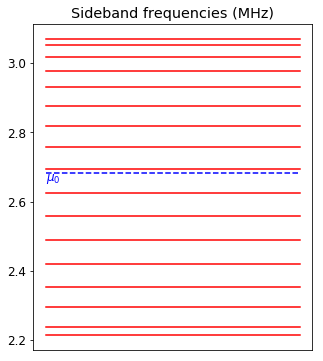

In [3]:
# Mode frequencies (red lines) and initial guess for suitable driving frequency (blue dashed line)
gate1.plot_modes()

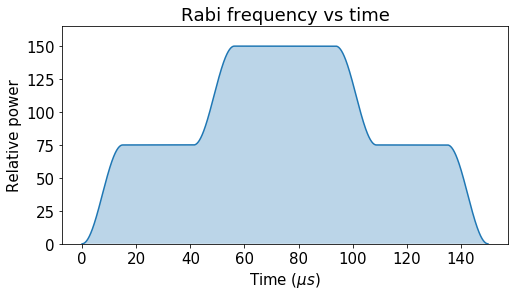

In [4]:
# You may edit initial guess for the amplitude in the amp_init function in the FM or AMFM class
gate1.plot_amp()

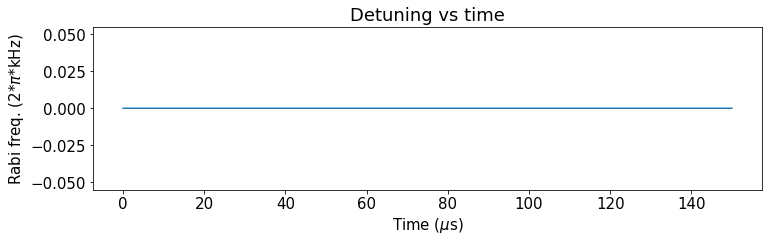

Starting freq =  2683377.0 Hz


In [5]:
# Plot frequency vs time
gate1.plot_freq()

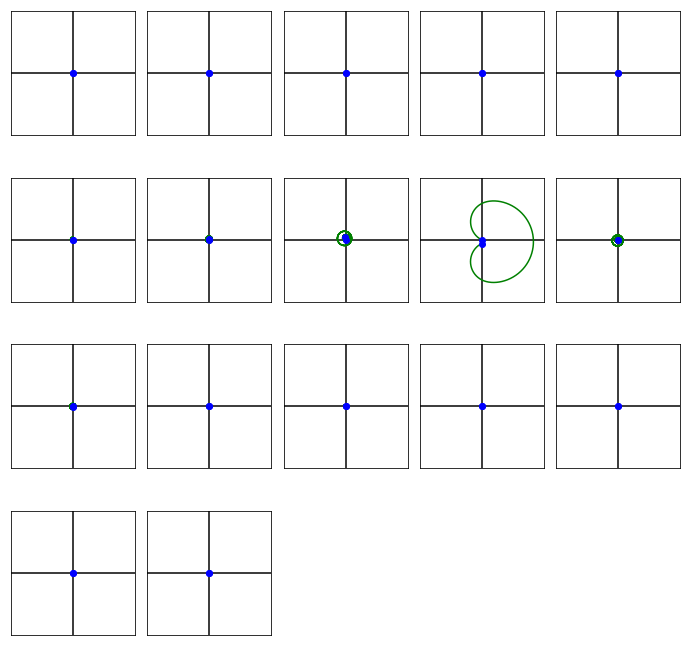

Error estimate (suppressed modes only) =  0.0011986668298681422
Displacement distances =  [6.70927e-07 1.85416e-05 8.96684e-05 1.61233e-05 2.75838e-04 5.82307e-04
 1.77778e-03 1.83305e-02 2.92991e-02 1.13501e-04 6.32199e-04 4.31866e-04
 9.27705e-05 5.35228e-05 1.47049e-04 1.09979e-05 6.08985e-05]


In [6]:
# Plot phase space trajectories
gate1.plot_psts(modes=[i for i in range(len(w_k))], zoom=0.7)

In [7]:
# Optimize with scipy
gate1.optimization(optimized_modes=[i for i in range(len(w_k))], maxiter=90)

Optimization terminated successfully.
         Current function value: 14567.418159
         Iterations: 52
         Function evaluations: 53
         Gradient evaluations: 53
Optimal beta =  [ -3.96627  -5.96601  13.95344 -13.51533  -1.10388   3.9498   -6.9871 ]


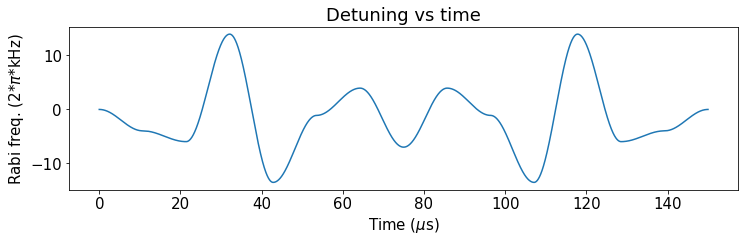

Starting freq =  2683377.0 Hz


In [8]:
# Optimal frequency pattern
gate1.plot_freq()

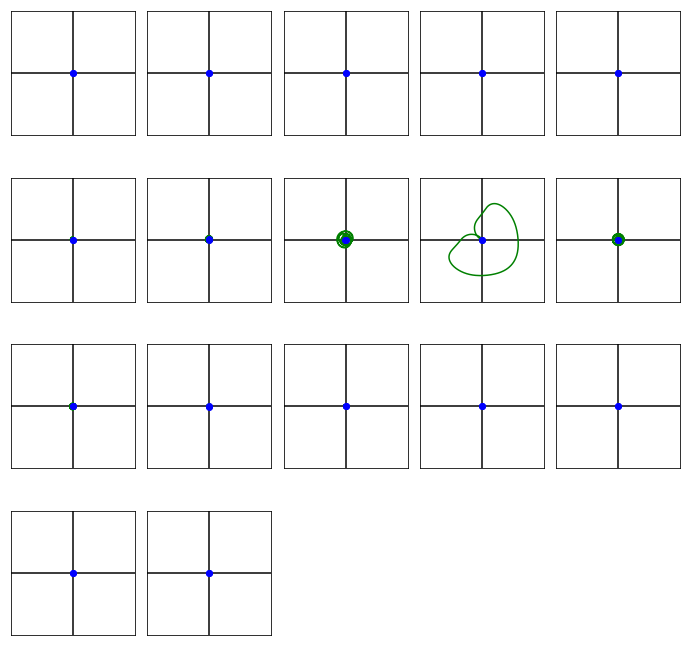

Error estimate (suppressed modes only) =  1.2124375994613815e-05
Displacement distances =  [1.43667e-05 1.39216e-05 6.17487e-05 9.04034e-06 2.64097e-04 2.55288e-04
 3.32189e-03 2.70802e-04 2.92060e-05 5.36808e-04 3.42626e-04 6.51502e-04
 1.20621e-04 1.39060e-05 1.48672e-04 2.43075e-05 9.25690e-05]


In [9]:
# Plot new PSTs
gate1.plot_psts(modes=[i for i in range(len(w_k))], zoom=0.7)

In [10]:
# To restart, set gate1.current_beta = gate1.init_beta (or any initial guess for frequency pattern)